In [1]:
import sys
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import interpolate 
sys.path.append(r'C:\Chuji\Code_and_Data\MyCode')

import Circuit_Simulator 
import PulseGenerator as PG
from toolfunc import *
from toolfunc.adia_analysis import *
from toolfunc.pulse_filter import *
import scipy.optimize as sci_op
from toolfunc import DE

{'Q1_freq': '6000.0MHz', 'Q1_anhar': '-125.0MHz', 'Q2_freq': '8500.0MHz', 'Q2_anhar': '-150.0MHz', 'Q3_freq': '5400.0MHz', 'Q3_anhar': '-125.0MHz', 'g12': '128.5457MHz', 'g13': '8.5381MHz', 'g23': '121.9492MHz'}


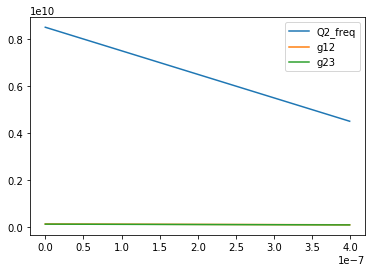

In [2]:
raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='ground',sampling_rate=1e9)
raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)

flux_pulse = np.linspace(0/7.5,4/7.5,400)
freq_array = 8.5e9-flux_pulse * (8.5e9 - 1e9)

raw_config.setValue('Q1 f01_max',6.0e9)
raw_config.setValue('Q2 f01_max',8.5e9)
raw_config.setValue('Q3 f01_max',5.4e9)
raw_config.setValue('Q1 f01_min',1e9)
raw_config.setValue('Q2 f01_min',1e9)
raw_config.setValue('Q3 f01_min',1e9)
raw_config.setValue('Q1 Ec',0.25e9)
raw_config.setValue('Q2 Ec',0.30e9)
raw_config.setValue('Q3 Ec',0.25e9)

raw_config.setValue('r12',0.018)
raw_config.setValue('r23',0.018)
raw_config.setValue('r13',0.0015)

raw_config.setValue('Q2 Voltage period',-1)
raw_config.setValue('Q2 Voltage operating point',0.00)
raw_config.setValue('Q2 Flux',flux_pulse)

simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
Simulator = Circuit_Simulator.Simulator(simu_config)
Simulator.show_pulse()

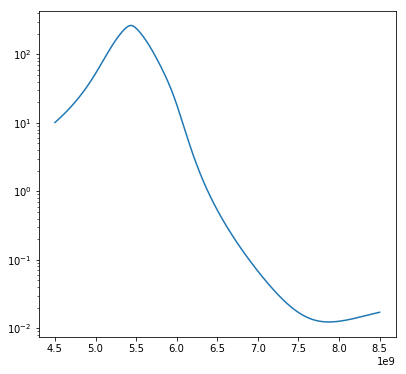

In [3]:
Simulator.performsimulation(solver_type=2,resample_factor=1,eigen_cloest_to_bare=False ,sort_by_maximum_overlap=True,gap=12e6)

fig = plt.figure(figsize=[6.4,6])
ax = fig.add_subplot(111)

eigen_trace = Simulator.EigenResult.get_Ener_gap_trace('101-100-001+000')
ax.plot(freq_array[0:400],-eigen_trace[0:400]/1e6)

ax.set_yscale('log')

In [4]:
%matplotlib inline

In [8]:
def cost_func_distor(pulse_params,*args):
    gate_time,SRATE,f_term,factor_r,T_reflec=args
#     str_idx = bin(int(factor_idx))[2:6].zfill(4)
    factor1=1.0 
    factorc=1.0 
    factor2=1.0 
    
    lamb1 = pulse_params
    total_len = gate_time + 12e-9+4*T_reflec
    
    Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
    Seq.clear_pulse(tips_on=False)
    Seq.add_pulse('Adiabatic',t0=gate_time/2+12e-9/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
                 CPLR_idle_freq=(7.87e9-6e9)*factorc+6e9,Q2_freq=6e9+(5.4e9-6e9)*factor2,constant_coupling=False,r1c=0.018*factor1,r2c=0.018*factor2,r12=0.0015*factorc,anhar_CPLR=-300e6*factorc,
                 anhar_Q1=-250e6*factor1,anhar_Q2=-250e6*factor2,negative_amplitude=False,dfdV=(7.87e9-6e9)*factorc+6e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
    Seq.add_filter('Gauss Low Pass',300e6)
    Seq.add_filter('Reflection',*(factor_r,T_reflec))
    flux_pulse=Seq.get_sequence()

    raw_config = Circuit_Simulator.RawConfig(qubit_num=3,dimension=3,circuit_type=1,initial_state='-Z+Z+Z',sampling_rate=SRATE)
    raw_config.load_default_value(modulation=True,decoherence=False,use_capacitance=False)
    
    raw_config.setValue('Q1 f01_max',6.0e9)
    raw_config.setValue('Q2 f01_max',7.87e9)
    raw_config.setValue('Q3 f01_max',5.4e9)
    raw_config.setValue('Q1 f01_min',1e9)
    raw_config.setValue('Q2 f01_min',1e9)
    raw_config.setValue('Q3 f01_min',1e9)
    raw_config.setValue('Q1 Ec',0.25e9)
    raw_config.setValue('Q2 Ec',0.3e9)
    raw_config.setValue('Q3 Ec',0.25e9)
    raw_config.setValue('r12',0.018)
    raw_config.setValue('r23',0.018)
    raw_config.setValue('r13',0.0015)
    
    raw_config.setValue('Q2 Voltage period',-1)
    raw_config.setValue('Q2 Voltage operating point',0)
    raw_config.setValue('Q2 Flux',flux_pulse)

    simu_config = Circuit_Simulator.read_config(raw_config.get_dict())
    Simulator = Circuit_Simulator.Simulator(simu_config)

    Simulator.performsimulation(solver_type=1)
    Simulator.UnitaryResult.get_U(-1)
    Simulator.UnitaryResult.get_subspace_operator(['000','001','100','101'])
    Simulator.UnitaryResult.remove_single_qubit_gate()
    Simulator.UnitaryResult.set_Target_gate('CZ')
    Simulator.UnitaryResult.get_Gate_Fidelity()
    fidelity = Simulator.UnitaryResult.Gate_Fidelity

    return 1 - fidelity

In [9]:
np.linspace(-0.1,0.1,21)
len(np.arange(0.5e-9,10.1e-9,0.5e-9))

20

In [10]:
SRATE=6e9
gate_time=30e-9
f_terms=1

Tr_arr = np.arange(0.5e-9,30.1e-9,1e-9)
factor_r_arr = np.linspace(-0.1,0.1,21)

gate_fidelity_one = np.zeros([len(Tr_arr),len(factor_r_arr)])
gate_params_one = np.zeros([len(Tr_arr),len(factor_r_arr)])
raw_initial_seeds=np.array([0.8])

ii = 0
for T_r in Tr_arr:
    jj = 0
    for factor_r in factor_r_arr:
        time_start = time.time()
        DATA = sci_op.minimize(cost_func_distor,raw_initial_seeds,args=(gate_time,SRATE,f_terms,factor_r,T_r), method='Nelder-Mead', options={'disp': True,'ftol':5e-5,'xtol':5e-5,'maxiter':30})

        gate_fidelity_one[ii,jj] = DATA.fun
        gate_params_one[ii,jj] = DATA.x
        
        print('fidelity',DATA.fun)
        print(time.time()-time_start)
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\params_one_distor_0ns_30ns.txt',gate_params_one )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\Robustness\error_one_distor_0ns_30ns.txt',gate_fidelity_one )
        jj+=1
    ii+=1

Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 11
         Function evaluations: 22
fidelity 1.5824870987724005e-05
46.534958839416504
Optimization terminated successfully.
         Current function value: 0.000016
         Iterations: 11
         Function evaluations: 22
fidelity 1.557433414445253e-05
47.190983057022095
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 11
         Function evaluations: 22
fidelity 1.532773634382867e-05
46.104512453079224
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 11
         Function evaluations: 22
fidelity 1.5074050600416555e-05
46.728596448898315
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 11
         Function evaluations: 22
fidelity 1.482857636259105e-05
46.39073133468628
Optimization terminated successfully.
         Current func

Optimization terminated successfully.
         Current function value: 0.010485
         Iterations: 11
         Function evaluations: 22
fidelity 0.01048548549887629
44.42688035964966
Optimization terminated successfully.
         Current function value: 0.007375
         Iterations: 11
         Function evaluations: 22
fidelity 0.007375061161124186
44.80623817443848
Optimization terminated successfully.
         Current function value: 0.004924
         Iterations: 11
         Function evaluations: 22
fidelity 0.0049236554638364405
44.537699937820435
Optimization terminated successfully.
         Current function value: 0.003078
         Iterations: 11
         Function evaluations: 22
fidelity 0.0030777135930539767
44.46731472015381
Optimization terminated successfully.
         Current function value: 0.001761
         Iterations: 11
         Function evaluations: 22
fidelity 0.0017607081700078409
46.10898399353027
Optimization terminated successfully.
         Current function val

Optimization terminated successfully.
         Current function value: 0.001871
         Iterations: 12
         Function evaluations: 24
fidelity 0.001871223030288749
52.4149432182312
Optimization terminated successfully.
         Current function value: 0.001506
         Iterations: 12
         Function evaluations: 24
fidelity 0.0015063054081597693
51.5946409702301
Optimization terminated successfully.
         Current function value: 0.001143
         Iterations: 11
         Function evaluations: 22
fidelity 0.0011433719150496513
48.187230825424194
Optimization terminated successfully.
         Current function value: 0.000754
         Iterations: 11
         Function evaluations: 22
fidelity 0.0007540270421203532
47.229339599609375
Optimization terminated successfully.
         Current function value: 0.000375
         Iterations: 11
         Function evaluations: 22
fidelity 0.0003748113789687757
47.44080638885498
Optimization terminated successfully.
         Current function va

Optimization terminated successfully.
         Current function value: 0.000672
         Iterations: 13
         Function evaluations: 26
fidelity 0.0006720766896949337
60.08405375480652
Optimization terminated successfully.
         Current function value: 0.000410
         Iterations: 12
         Function evaluations: 24
fidelity 0.00040971792737110047
55.3041787147522
Optimization terminated successfully.
         Current function value: 0.000189
         Iterations: 11
         Function evaluations: 22
fidelity 0.00018916052736095423
51.043538093566895
Optimization terminated successfully.
         Current function value: 0.000043
         Iterations: 11
         Function evaluations: 22
fidelity 4.272382049586021e-05
50.94040107727051
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 11
         Function evaluations: 22
fidelity 1.3481104094492657e-05
50.46903443336487
Optimization terminated successfully.
         Current functio

Optimization terminated successfully.
         Current function value: 0.000271
         Iterations: 12
         Function evaluations: 24
fidelity 0.0002709980149188107
59.02207922935486
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 11
         Function evaluations: 22
fidelity 5.529304560336623e-05
54.45421075820923
Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 11
         Function evaluations: 22
fidelity 1.348210098983671e-05
53.84354615211487
Optimization terminated successfully.
         Current function value: 0.000171
         Iterations: 12
         Function evaluations: 24
fidelity 0.00017069076753173373
59.79438281059265
Optimization terminated successfully.
         Current function value: 0.000554
         Iterations: 13
         Function evaluations: 26
fidelity 0.0005540956841376676
64.31343865394592
Optimization terminated successfully.
         Current function 

Optimization terminated successfully.
         Current function value: 0.000013
         Iterations: 11
         Function evaluations: 22
fidelity 1.348305885717771e-05
57.07114052772522
Optimization terminated successfully.
         Current function value: 0.000251
         Iterations: 12
         Function evaluations: 24
fidelity 0.0002507361484335169
62.93811845779419
Optimization terminated successfully.
         Current function value: 0.000878
         Iterations: 13
         Function evaluations: 26
fidelity 0.0008776211923213761
68.48650360107422
Optimization terminated successfully.
         Current function value: 0.001663
         Iterations: 14
         Function evaluations: 28
fidelity 0.001663223401177527
73.44873523712158
Optimization terminated successfully.
         Current function value: 0.002803
         Iterations: 14
         Function evaluations: 28
fidelity 0.002802790557122181
73.5627715587616
Optimization terminated successfully.
         Current function valu

Optimization terminated successfully.
         Current function value: 0.000080
         Iterations: 13
         Function evaluations: 26
fidelity 8.025605420503013e-05
71.58561873435974
Optimization terminated successfully.
         Current function value: 0.000135
         Iterations: 14
         Function evaluations: 28
fidelity 0.0001351231807564801
76.97809958457947
Optimization terminated successfully.
         Current function value: 0.000236
         Iterations: 15
         Function evaluations: 30
fidelity 0.00023558394296363527
82.94650077819824
Optimization terminated successfully.
         Current function value: 0.000538
         Iterations: 15
         Function evaluations: 30
fidelity 0.000538104604319023
83.22996068000793
Optimization terminated successfully.
         Current function value: 0.001297
         Iterations: 15
         Function evaluations: 30
fidelity 0.0012973045799266059
82.68630862236023
Optimization terminated successfully.
         Current function v

Optimization terminated successfully.
         Current function value: 0.000028
         Iterations: 15
         Function evaluations: 30
fidelity 2.7687674047482957e-05
87.4314374923706
Optimization terminated successfully.
         Current function value: 0.000070
         Iterations: 15
         Function evaluations: 30
fidelity 7.026346454575005e-05
87.56960535049438
Optimization terminated successfully.
         Current function value: 0.000299
         Iterations: 15
         Function evaluations: 30
fidelity 0.0002989959310163437
87.21534967422485
Optimization terminated successfully.
         Current function value: 0.000786
         Iterations: 16
         Function evaluations: 32
fidelity 0.0007861294551939624
93.12602138519287
Optimization terminated successfully.
         Current function value: 0.001453
         Iterations: 16
         Function evaluations: 32
fidelity 0.0014527538203261692
93.20964074134827
Optimization terminated successfully.
         Current function v

Optimization terminated successfully.
         Current function value: 0.000301
         Iterations: 15
         Function evaluations: 30
fidelity 0.00030114692013916144
91.77404642105103
Optimization terminated successfully.
         Current function value: 0.000791
         Iterations: 16
         Function evaluations: 32
fidelity 0.0007911291942817034
98.37324476242065
Optimization terminated successfully.
         Current function value: 0.001464
         Iterations: 16
         Function evaluations: 32
fidelity 0.0014638283576740019
97.78502655029297
Optimization terminated successfully.
         Current function value: 0.002182
         Iterations: 16
         Function evaluations: 32
fidelity 0.002181909494405665
98.07978463172913
Optimization terminated successfully.
         Current function value: 0.002859
         Iterations: 16
         Function evaluations: 32
fidelity 0.002858829595556056
97.90916609764099
Optimization terminated successfully.
         Current function va

Optimization terminated successfully.
         Current function value: 0.001419
         Iterations: 16
         Function evaluations: 32
fidelity 0.001419343558344388
102.95325970649719
Optimization terminated successfully.
         Current function value: 0.002109
         Iterations: 16
         Function evaluations: 32
fidelity 0.002108652010873735
102.33523750305176
Optimization terminated successfully.
         Current function value: 0.002748
         Iterations: 16
         Function evaluations: 32
fidelity 0.0027478109593663813
102.70269870758057
Optimization terminated successfully.
         Current function value: 0.003555
         Iterations: 11
         Function evaluations: 22
fidelity 0.003554765799821946
72.60594511032104
Optimization terminated successfully.
         Current function value: 0.002594
         Iterations: 12
         Function evaluations: 24
fidelity 0.0025942870240170945
79.0254077911377
Optimization terminated successfully.
         Current function va

Optimization terminated successfully.
         Current function value: 0.002711
         Iterations: 16
         Function evaluations: 33
fidelity 0.0027112618031348568
110.88007235527039
Optimization terminated successfully.
         Current function value: 0.003545
         Iterations: 11
         Function evaluations: 22
fidelity 0.0035448179921246936
75.32341194152832
Optimization terminated successfully.
         Current function value: 0.002589
         Iterations: 12
         Function evaluations: 24
fidelity 0.0025891705992595604
81.85649061203003
Optimization terminated successfully.
         Current function value: 0.001698
         Iterations: 13
         Function evaluations: 26
fidelity 0.0016982561428540155
88.84216380119324
Optimization terminated successfully.
         Current function value: 0.001058
         Iterations: 14
         Function evaluations: 28
fidelity 0.0010577866525993684
95.64318251609802
Optimization terminated successfully.
         Current function 

Optimization terminated successfully.
         Current function value: 0.002698
         Iterations: 12
         Function evaluations: 24
fidelity 0.00269823943724834
86.17391562461853
Optimization terminated successfully.
         Current function value: 0.001758
         Iterations: 13
         Function evaluations: 26
fidelity 0.0017577410226788936
92.28339147567749
Optimization terminated successfully.
         Current function value: 0.001086
         Iterations: 14
         Function evaluations: 28
fidelity 0.0010860635795532092
100.77683472633362
Optimization terminated successfully.
         Current function value: 0.000008
         Iterations: 15
         Function evaluations: 30
fidelity 8.001225018761104e-06
105.50645756721497
Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 15
         Function evaluations: 30
fidelity 6.750565576196799e-06
105.73750519752502
Optimization terminated successfully.
         Current function 

KeyboardInterrupt: 

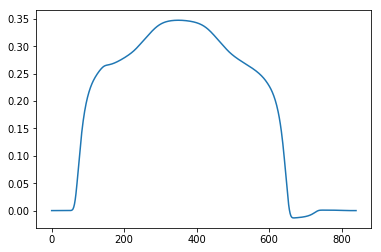

In [7]:
gate_time=60e-9
SRATE=10e9
f_term=2
factor_r=-0.06
T_reflex=4e-9

factor1=1.0 
factorc=1.0 
factor2=1.0 

lamb1 = [0.8,-0.1]
total_len = gate_time + 8e-9+4*T_reflex

Seq=PG.Sequence(total_len=total_len,sample_rate=SRATE,complex_trace=False)
Seq.clear_pulse(tips_on=False)
Seq.add_pulse('Adiabatic',t0=gate_time/2+12e-9/2,width=gate_time,plateau=0e-9,frequency=0,F_Terms=f_term,Lcoeff=np.array(lamb1),Q1_freq=6.0e9,
             CPLR_idle_freq=(7.87e9-6e9)*factorc+6e9,Q2_freq=6e9+(5.4e9-6e9)*factor2,constant_coupling=False,r1c=0.018*factor1,r2c=0.018*factor2,r12=0.0015*factorc,anhar_CPLR=-300e6*factorc,
             anhar_Q1=-250e6*factor1,anhar_Q2=-250e6*factor2,negative_amplitude=False,dfdV=(7.87e9-6e9)*factorc+6e9-1e9,gap_threshold=8e6,freqpoints=301,pulsepoints=601)
Seq.add_filter('Gauss Low Pass',300e6)
Seq.add_filter('Reflection',*(factor_r,T_reflex))
flux_pulse=Seq.get_sequence()

plt.plot(flux_pulse)

In [8]:
%matplotlib inline

In [90]:
SRATE=10e9
f_terms=1
gate_time_arr = np.arange(12e-9,60.1e-9,1e-9)

for fac_idx in np.arange(0,7.1,1):
    gate_fidelity_one = []
    gate_params_one = []
    raw_initial_seeds=np.array([3])
    for gate_time in gate_time_arr:
        time_start = time.time()
        DATA = sci_op.minimize(cost_func_inhomogeneity,raw_initial_seeds,args=(gate_time,SRATE,f_terms,fac_idx,0.05), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})
    #     DATA = sci_op.minimize(cost_func,raw_initial_seeds,args=(gate_time,SRATE,f_terms), method='Nelder-Mead', options={'disp': True,'ftol':1e-5,'xtol':1e-5,'maxiter':30})

        gate_fidelity_one.append(DATA.fun)
        gate_params_one.append(DATA.x)
        raw_initial_seeds =DATA.x*0.92
        print('gate time',gate_time)
        print('fidelity',DATA.fun)
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\params_one_5_inhomo'+str(fac_idx)+'.txt',gate_params_one )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\error_one_5_inhomo'+str(fac_idx)+'.txt',gate_fidelity_one )
        np.savetxt(r'C:\Chuji\Latex_Papers\Mypapers\ZZ_coupling_20210205\fig_zz\fig3_data\gate_time_one_5_inhomo'+str(fac_idx)+'.txt',gate_time_arr )